##### Figures S3-4 and Table S4: genome-wide pi and Tajima's D

In [1]:
from collections import defaultdict
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import allel
import seaborn as sns

import ingenos

In [2]:
base_path = "/overflow/dschridelab/users/rrlove/aedes/"
md_path = f"{base_path}metadata/"
results_path = f"{base_path}results/"
zarr_path = "/proj/dschridelab/rrlove/aedes/vcf/filtered_110122/"

In [3]:
def return_data(zarr_path, data_type, data_name):
    
    fetch_str = f"{data_type}/{data_name}" 
    
    return da.from_zarr(zarr_path, component=fetch_str)

In [4]:
chroms_dict = defaultdict(dict)

chroms = ["AaegL5_1", "AaegL5_2", "AaegL5_3"]

for chrom in chroms:
    
    temp_in_path = zarr_path + chrom

    chroms_dict[chrom]["pos"] = return_data(temp_in_path, "variants", "POS")
    chroms_dict[chrom]["chrom"] = return_data(temp_in_path, "variants", "CHROM")
    chroms_dict[chrom]["ref"] = return_data(temp_in_path, "variants", "REF")
    chroms_dict[chrom]["alt"] = return_data(temp_in_path, "variants", "ALT")
    chroms_dict[chrom]["ac"] = return_data(temp_in_path, "variants", "AC")
    chroms_dict[chrom]["qd"] = return_data(temp_in_path, "variants", "QD")
    chroms_dict[chrom]["mq"] = return_data(temp_in_path, "variants", "MQ")
    chroms_dict[chrom]["fs"] = return_data(temp_in_path, "variants", "FS")
    chroms_dict[chrom]["mqrs"] = return_data(temp_in_path, "variants", "MQRankSum")
    chroms_dict[chrom]["rprs"] = return_data(temp_in_path, "variants", "ReadPosRankSum")
    chroms_dict[chrom]["sor"] = return_data(temp_in_path, "variants", "SOR")
    chroms_dict[chrom]["is_snp"] = return_data(temp_in_path, "variants", "is_snp")
    chroms_dict[chrom]["numalt"] = return_data(temp_in_path, "variants", "numalt")
    chroms_dict[chrom]["filter_pass"] = return_data(temp_in_path, "variants", "FILTER_PASS")

    chroms_dict[chrom]["gt"] = return_data(temp_in_path, "calldata", "GT")
    chroms_dict[chrom]["gq"] = return_data(temp_in_path, "calldata", "GQ")
    chroms_dict[chrom]["ad"] = return_data(temp_in_path, "calldata", "AD")
    chroms_dict[chrom]["pl"] = return_data(temp_in_path, "calldata", "PL")
    chroms_dict[chrom]["dp"] = return_data(temp_in_path, "calldata", "DP")
    
    print(chrom, chroms_dict[chrom]["gt"].shape)
    
samples = da.from_zarr(temp_in_path, component="samples")

AaegL5_1 (18443972, 131, 2)
AaegL5_2 (32930875, 131, 2)
AaegL5_3 (27660249, 131, 2)


In [5]:
np.sum([chroms_dict[chrom]["gt"].shape[0] for chrom in chroms])

79035096

In [6]:
md = pd.read_table(
    md_path + "whole_sample_sorted_country.031522.csv", 
    sep="\t",)

md["locality"] = md["location"].str.split(": ", expand=True)[1]

md.head()

,sample_id,sample_short,location,sex,batch,sample_id_cat,country,locality
0,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,FEMALE_1,Colombia: Rio Claro,F,1,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,Colombia,Rio Claro
1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,FEMALE_10,Colombia: Rio Claro,F,1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,Colombia,Rio Claro
2,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,FEMALE_11,Colombia: Rio Claro,F,1,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,Colombia,Rio Claro
3,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,FEMALE_12,Colombia: Rio Claro,F,1,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,Colombia,Rio Claro
4,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,FEMALE_14,Colombia: Rio Claro,F,1,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,Colombia,Rio Claro


In [7]:
np.sum(~(md["sample_id"] == samples.compute()))

0

##### drop close kin

In [8]:
to_drop = np.loadtxt(md_path + "close_kin_removed_new_dataset.txt",
                    dtype=str)

to_drop_bool = (~(md["sample_short"].isin(to_drop)).values)

np.sum(to_drop_bool)

123

In [9]:
md_filtered = md.loc[to_drop_bool]

md_filtered.shape

(123, 8)

##### set up the country filters

In [10]:
countries = ["Brazil", "Colombia", "USA", "Gabon", "Kenya", "Senegal"]

country_bools = {}

for country in countries:
    
    country_bools[country] = (md_filtered["country"] == country).values
    
country_bools.keys()

dict_keys(['Brazil', 'Colombia', 'USA', 'Gabon', 'Kenya', 'Senegal'])

##### read in the repeat and mappability masks

In [11]:
rep_mask_path = \
f"{base_path}refs/aegy/accessibility/accessibility"

repeat_masks = {}

for chrom in chroms:
    
    repeat_masks[chrom] = da.from_zarr(rep_mask_path, component=chrom)
    
map_mask_path = \
f"{base_path}refs/aegy/mappability/masks"

map_masks = {}

for chrom in chroms:
    
    map_masks[chrom] = da.from_zarr(map_mask_path, component=chrom)

In [12]:
pi_dict = defaultdict(lambda: defaultdict(dict))
d_dict = defaultdict(lambda: defaultdict(dict))

for chrom in chroms:
    
    rep_mask = repeat_masks[chrom]
    map_mask = map_masks[chrom]
    
    for country, country_flt in country_bools.items():
    
        gt = allel.GenotypeArray(chroms_dict[chrom]["gt"])\
        .subset(sel1 = to_drop_bool).subset(sel1 = country_flt)
        
        ##mask genotypes with quality below 20
        gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
        
        gt.mask = gq < 20
        
        ##5 Mb sliding windows, with repetitive and unmappable regions masked (for pi) 
        pi, windows, n_bases, counts = allel.windowed_diversity(
        chroms_dict[chrom]["pos"].compute(), gt.count_alleles(), 
            size=5000000,
        step=500000, is_accessible=(rep_mask & map_mask))
    
        pi_dict["overlapping"][chrom][country] = \
        (pi, windows, n_bases, counts)
        
        d, windows, counts = allel.windowed_tajima_d(
        chroms_dict[chrom]["pos"].compute(), gt.count_alleles(), size=5000000,
        step=500000)
        
        d_dict["overlapping"][chrom][country] = (d, windows, counts)
        
        ##500 kb nonoverlapping windows, same filters and masking
        pi, windows, n_bases, counts = allel.windowed_diversity(
        chroms_dict[chrom]["pos"].compute(), gt.count_alleles(), 
            size=500000, is_accessible=(rep_mask & map_mask))
    
        pi_dict["nonoverlapping"][chrom][country] = \
        (pi, windows, n_bases, counts)
        
        d, windows, counts = allel.windowed_tajima_d(
        chroms_dict[chrom]["pos"].compute(), gt.count_alleles(), size=500000)
        
        d_dict["nonoverlapping"][chrom][country] = (d, windows, counts)
        
        print(chrom, country)

<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_1 Brazil


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_1 Colombia


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_1 USA


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_1 Gabon


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_1 Kenya


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_1 Senegal


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_2 Brazil


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_2 Colombia


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_2 USA


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_2 Gabon


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_2 Kenya


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_2 Senegal


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_3 Brazil


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_3 Colombia


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_3 USA


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_3 Gabon


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_3 Kenya


<ipython-input-12-c2d295451934>:15: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq = chroms_dict[chrom]["gq"][:, to_drop_bool][:, country_flt]
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/util.py:187: UserWarning: Some variants were inaccessible and hence masked.
  warnings.warn("Some variants were inaccessible and hence masked.")


AaegL5_3 Senegal


In [13]:
outString = ingenos.make_date_stamp(
    results_path + "popgen/pi_D_along_chrom_by_pop_5_Mb", ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/popgen/pi_D_along_chrom_by_pop_5_Mb.020823.pdf'

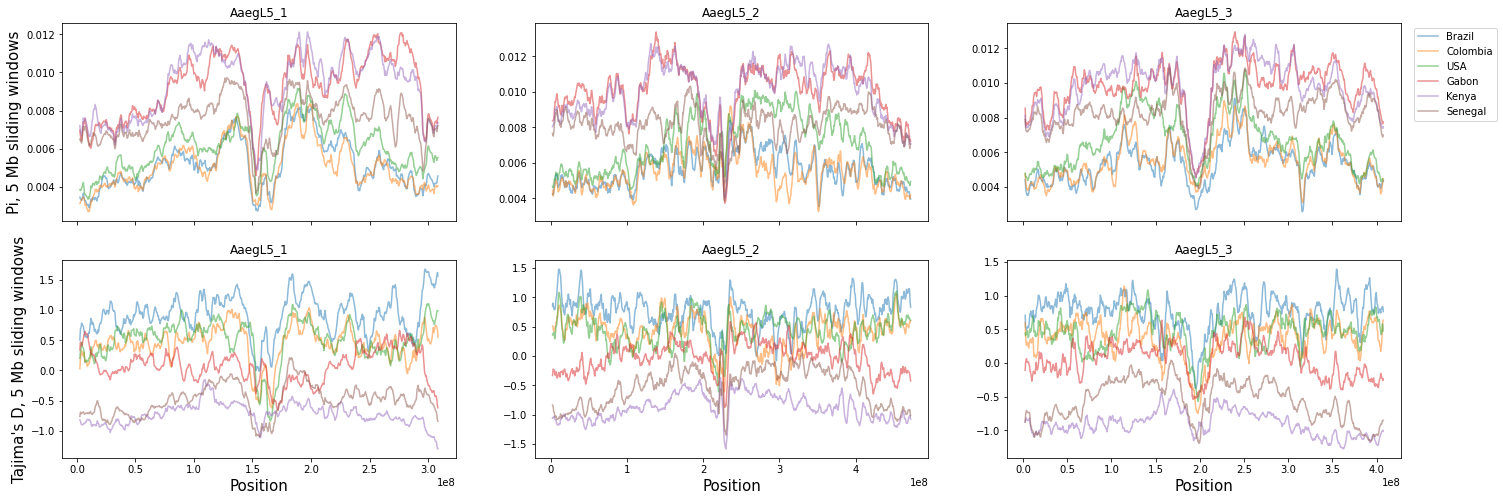

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 8), sharex="col")

for i, chrom in enumerate(chroms):
    
    ax = axes[:, i]
    
    for country in country_bools.keys():
        
        pi, pi_windows, n_bases, pi_counts = pi_dict["overlapping"][chrom][country]

        d, d_windows, d_counts = d_dict["overlapping"][chrom][country]
    
        ax[0].plot(np.mean(pi_windows, axis=1), pi, label=country, alpha=0.5)

        ax[1].plot(np.mean(d_windows, axis=1), d, label=country, alpha=0.5)
    
    
    ax[0].set_title(chrom)
    ax[1].set_title(chrom)
    ax[1].set_xlabel("Position", fontsize=15)
    
axes[0][0].set_ylabel("Pi, 5 Mb sliding windows", fontsize=15)
axes[1][0].set_ylabel("Tajima's D, 5 Mb sliding windows", fontsize=15)
axes[0][2].legend(bbox_to_anchor=(1.02, 1))
    
#plt.savefig(outString, bbox_inches="tight")

##### averages

In [15]:
for country in country_bools.keys():
    
    pi_list = []
    
    d_list = []
    
    for chrom in chroms:
    
        pi, _, _, _ = pi_dict["nonoverlapping"][chrom][country]

        d, _, _ = d_dict["nonoverlapping"][chrom][country]

        pi_list.append(pi)
        
        d_list.append(d)
        
    all_pi = np.concatenate(pi_list)
    
    all_d = np.concatenate(d_list)
    
    print(country)
    
    print("total # pi windows: ", len(all_pi))
    print("total # D windows: ", len(all_d), "\n")
    
    print("mean pi is: ", np.mean(all_pi))
    print("median pi is: ", np.median(all_pi))
    
    print("mean Tajima's D is: ", np.mean(all_d))
    print("median Tajima's D is: ", np.median(all_d), "\n")

Brazil
total # pi windows:  2391
total # D windows:  2391 

mean pi is:  0.005390448270066387
median pi is:  0.005278018951930091
mean Tajima's D is:  0.8031531003570727
median Tajima's D is:  0.8407943390729465 

Colombia
total # pi windows:  2391
total # D windows:  2391 

mean pi is:  0.005367805911105543
median pi is:  0.005262005378108322
mean Tajima's D is:  0.406856790322233
median Tajima's D is:  0.4588261059579707 

USA
total # pi windows:  2391
total # D windows:  2391 

mean pi is:  0.0066522985161808395
median pi is:  0.006418255961674087
mean Tajima's D is:  0.4628093753927301
median Tajima's D is:  0.4991688751118426 

Gabon
total # pi windows:  2391
total # D windows:  2391 

mean pi is:  0.009720815614294474
median pi is:  0.009887877254338578
mean Tajima's D is:  0.0414389040749373
median Tajima's D is:  0.03707127107174021 

Kenya
total # pi windows:  2391
total # D windows:  2391 

mean pi is:  0.00968188780299935
median pi is:  0.009867178193654137
mean Tajima's D i

##### distributions

In [16]:
outString = ingenos.make_date_stamp(
    results_path + "popgen/pi_D_distribution_by_chrom", ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/popgen/pi_D_distribution_by_chrom.020823.pdf'

Text(0.5, 1.0, "Tajima's D, 500 kb non-overlapping windows")

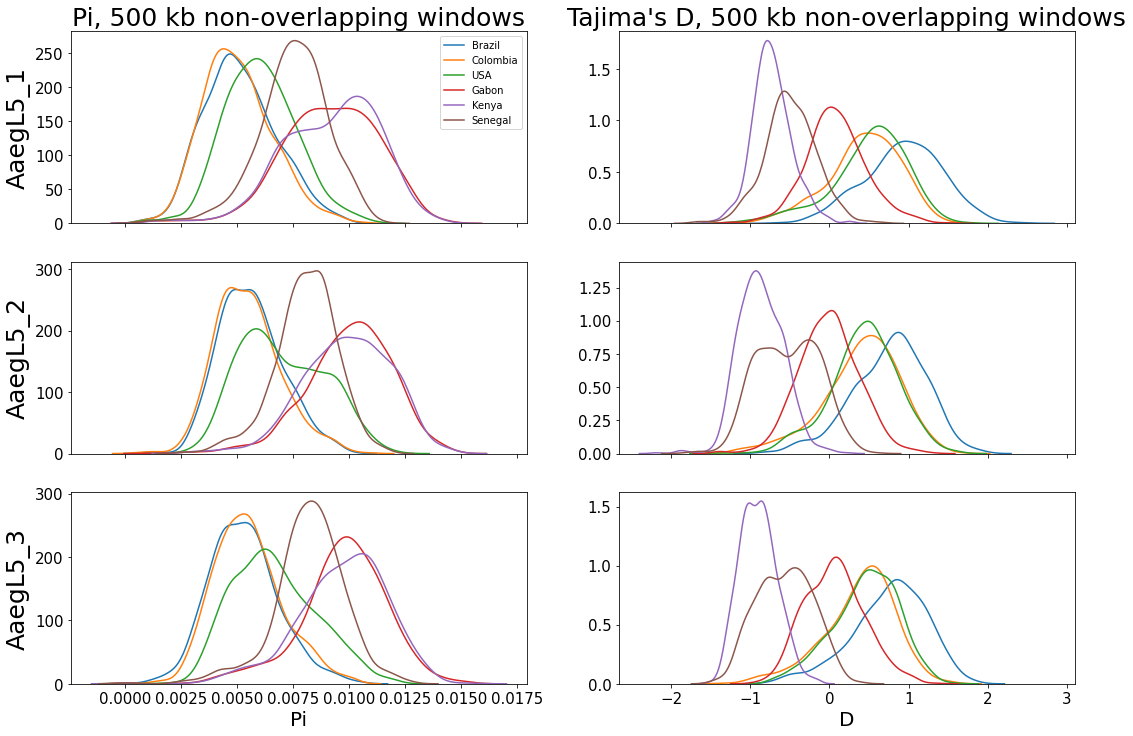

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharex="col")

for i, chrom in enumerate(chroms):
    
    ax = axes[i]
    
    for country in country_bools.keys():
    
        pi, _, _, _ = pi_dict["nonoverlapping"][chrom][country]

        d, _, _ = d_dict["nonoverlapping"][chrom][country]

        sns.kdeplot(data=pi, ax=ax[0], label=country)
        ax[0].set_ylabel(chrom, fontsize=25)

        sns.kdeplot(data=d, ax=ax[1], label=country)
        ax[1].set_ylabel("")
    
    ax[0].tick_params(labelsize=15)
    ax[1].tick_params(labelsize=15)
    
ax[0].set_xlabel("Pi", fontsize=20)
ax[1].set_xlabel("D", fontsize=20)
    
axes[0][0].legend()
axes[0][0].set_title("Pi, 500 kb non-overlapping windows", fontsize=25)
axes[0][1].set_title("Tajima's D, 500 kb non-overlapping windows", fontsize=25)

#plt.savefig(outString, bbox_inches="tight")